# Plan-and-Execute

This notebook shows how to create a "plan-and-execute" style agent. This is heavily inspired by the [Plan-and-Solve](https://arxiv.org/abs/2305.04091) paper as well as the [Baby-AGI](https://github.com/yoheinakajima/babyagi) project.

The core idea is to first come up with a multi-step plan, and then go through that plan one item at a time.
After accomplishing a particular task, you can then revisit the plan and modify as appropriate.


The general computational graph looks like the following:

![plan-and-execute diagram](attachment:86cf6404-3d9b-41cb-ab97-5e451f576620.png)


This compares to a typical [ReAct](https://arxiv.org/abs/2210.03629) style agent where you think one step at a time.
The advantages of this "plan-and-execute" style agent are:

1. Explicit long term planning (which even really strong LLMs can struggle with)
2. Ability to use smaller/weaker models for the execution step, only using larger/better models for the planning step


The following walkthrough demonstrates how to do so in LangGraph. The resulting agent will leave a trace like the following example: ([link](https://smith.langchain.com/public/d46e24d3-dda6-44d5-9550-b618fca4e0d4/r)).

## Setup

First, we need to install the packages required.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-community langchain-openai tavily-python

Next, we need to set API keys for OpenAI (the LLM we will use) and Tavily (the search tool we will use)

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

OPENAI_API_KEY: ··········
TAVILY_API_KEY: ··········


<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>.
    </p>
</div>

## Define Tools

We will first define the tools we want to use. For this simple example, we will use a built-in search tool via Tavily. However, it is really easy to create your own tools - see documentation [here](https://python.langchain.com/docs/how_to/custom_tools) on how to do that.

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

## Define our Execution Agent

Now we will create the execution agent we want to use to execute tasks.
Note that for this example, we will be using the same execution agent for each task, but this doesn't HAVE to be the case.

In [ ]:
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Get the prompt to use - you can modify this!
prompt = hub.pull("ih/ih-react-agent-executor")
prompt.pretty_print()

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4-turbo-preview")
agent_executor = create_react_agent(llm, tools, state_modifier=prompt)

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{messages}


In [ ]:
agent_executor.invoke({"messages": [("user", "who is the winnner of the us open")]})

{'messages': [HumanMessage(content='who is the winnner of the us open', additional_kwargs={}, response_metadata={}, id='9a9607b7-28ab-4552-be2f-b686987e9306'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_t0odTeKG5o0rctutZnKJIkre', 'function': {'arguments': '{"query":"US Open 2023 winner"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 97, 'total_tokens': 120, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0125-preview', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d88f9f09-4893-474c-91f2-c2883459b0e7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'US Open 2023 winner'}, 'id': 'call_t0odTeKG5o0rctutZnKJIkre', 'type': 'tool_call'}], usage_metadata={'input_tokens': 97, 

## Define the State

Let's now start by defining the state the track for this agent.

First, we will need to track the current plan. Let's represent that as a list of strings.

Next, we should track previously executed steps. Let's represent that as a list of tuples (these tuples will contain the step and then the result)

Finally, we need to have some state to represent the final response as well as the original input.

In [ ]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

## Planning Step

Let's now think about creating the planning step. This will use function calling to create a plan.

<div class="admonition note">
    <p class="admonition-title">Using Pydantic with LangChain</p>
    <p>
        This notebook uses Pydantic v2 <code>BaseModel</code>, which requires <code>langchain-core >= 0.3</code>. Using <code>langchain-core < 0.3</code> will result in errors due to mixing of Pydantic v1 and v2 <code>BaseModels</code>.
    </p>
</div>

In [ ]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Plan)

In [ ]:
planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the current Australia open winner?")
        ]
    }
)

Plan(steps=['Identify the current year.', 'Determine the winner of the Australian Open for the current year.', 'Research the hometown of the identified winner.'])

## Re-Plan Step

Now, let's create a step that re-does the plan based on the result of the previous step.

In [ ]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Act)

## Create the Graph

We can now create the graph!

In [ ]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [ ]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

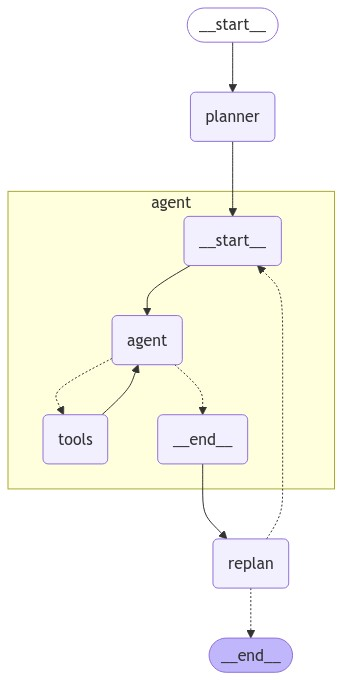

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
config = {"recursion_limit": 50}
inputs = {"input": """I need to help me assess my company Toast for IPO readiness and create a report.
IPO Readiness is measured by comparing my company (in the fintech industry) with a prior company (Marqueta) in my industry that have gone through IPO.
The IPO Readiness should measure across “financial metrics” (Revenue, ARR, Growth etc), “Margin metrics” (Gross, Net, Operating, EBITDA etc) and “forward guidance given in each quarter compared to actuals”
Your task is to compare the financial metrics as defined above for Toast and Marqueta over the past year from 2023 to 2024 and give a detailed report like a spreadsheet """}
ans = []

async for event in app.astream(inputs, config=config):

    for k, v in event.items():
        ans.append({k:v})
        if k != "__end__":
            print(k,v)

planner {'plan': ['Collect financial data for Toast and Marqueta for the year 2023 to 2024, focusing on Revenue, ARR, and Growth metrics.', 'Collect margin metrics data for Toast and Marqueta for the year 2023 to 2024, focusing on Gross, Net, Operating, and EBITDA margins.', 'Collect data on forward guidance and actuals for each quarter for Toast and Marqueta for the year 2023 to 2024.', 'Create a spreadsheet with separate sections for financial metrics, margin metrics, and forward guidance vs actuals.', 'In the financial metrics section, list the Revenue, ARR, and Growth for each company by quarter.', 'In the margin metrics section, list the Gross, Net, Operating, and EBITDA margins for each company by quarter.', 'In the forward guidance vs actuals section, compare the forward guidance given by each company with the actual results for each quarter.', "Analyze the data to identify trends, strengths, and weaknesses in Toast's financial and margin metrics compared to Marqueta.", 'Summari

In [ ]:
final_planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a friendly assistant""",
        ),
        ("placeholder", "{messages}"),
    ]
)
final_planner = final_planner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
)

In [ ]:
query = """Take the context provided, and write a spreadsheet report about IPO readiness for Toast in comparison with Marqueta.
The IPO Readiness should measure across “financial metrics” (Revenue, ARR, Growth etc), “Margin metrics” (Gross, Net, Operating, EBITDA etc) and “forward guidance given in each quarter compared to actuals”
Your task is to compare the financial metrics as defined above for Toast and Marqueta over the past year from 2023 to 2024 and give a detailed report like a spreadsheet
solely based on the context."""

resp = final_planner.invoke(
    {
        "messages": [
            ("user", f"""Query: {query}
             context: f{ans}""")
        ]
    }
)

In [ ]:
print(resp.content)

Based on the context provided, here is a detailed spreadsheet report comparing the IPO readiness of Toast and Marqueta across financial metrics, margin metrics, and forward guidance versus actuals for the year 2023 to 2024.

### Spreadsheet Report

#### Financial Metrics

| Company  | Quarter | Revenue Growth (%) | ARR ($ Million) | ARR Growth (%) |
|----------|---------|--------------------|-----------------|----------------|
| Toast    | Q4 2023 | +41.52%            | 1,218           | +35%           |
| Marqueta | Q2 2023 | +24%               | N/A             | N/A            |
| Marqueta | Q4 2023 | -9.63%             | N/A             | N/A            |

#### Margin Metrics

| Company  | Quarter | Gross Margin (%) | Net Margin (%) | Operating Margin (%) | EBITDA Margin (%) |
|----------|---------|------------------|----------------|----------------------|-------------------|
| Toast    | Q1 2024 | 23.03%           | -3.1%          | N/A                  | N/A               |
| Ma

## Conclusion

Congrats on making a plan-and-execute agent! One known limitations of the above design is that each task is still executed in sequence, meaning embarrassingly parallel operations all add to the total execution time. You could improve on this by having each task represented as a DAG (similar to LLMCompiler), rather than a regular list.